# Shedding Light on the Dark: Analyzing the Proportion of Daytime vs Nighttime Thefts in Vancouver

Group 2: Rui Xiang Yu, Lily Zhang, Bill Makwae & Ruoxi Chen

### 1. Introduction
Vancouver's population was reported to be of 662,248 in 2021, making it one of the biggest cities in Canada (Statistics Canada, 2023). As such, it is expected for crimes, such as theft, to happen. 

With this project, we aim to answer the following inferential question: does the proportion of theft-related crimes commited in the day differ from those commited in the night? The conclusions from this project could be extrapolated to the entirety of Vancouver and other Canadian cities of similar population density.

It was found that predicted robbery rates in the United Kingdom increased the darker the areas were (Tompson & Bowers, 2013). Furthermore, commercial robberies in the Netherlands happened more during winter due to more dark hours during the season (Van Koppen & Jansen, 1999). Based on the current literature, our hypothesis is that the proportion of theft is higher at night. Due to the dark and less witnesses, it is easier to stay concealed and carry out a successful theft.

The dataset used for this project is the Vancouver Police Department's Crime Data, which contains the data about most crimes commited in Vancouver, and the variables "hour" and "number of crimes" will be used (Vancouver Police Department, 2023). Since the main focus is the count of crimes comitted on the day VS night, the proportion of crimes in the day VS night will be studied. Furthermore, the standard deviation will be studied too in order to report a confidence interval.

### 2. Preliminary Results

In [1]:
#Loading all necessary libraries.
library(dplyr)
library(ggplot2)
library(cowplot)
library(datateachr)
library(digest)
library(infer)
library(repr)
library(taxyvr)
library(tidyverse)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8     ✔ purrr   0.3.4
✔ tidyr   1.2.1     ✔ stringr 1.4.1
✔ readr   2.1.2     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [3]:
#Reading the dataset from the web into Jupyter and previewing the first 6 rows.
vancouver_crime_data <- read.csv(url("https://raw.githubusercontent.com/xnrxng/stat201project/main/crimedata_csv_AllNeighbourhoods_AllYears.csv"))
head(vancouver_crime_data)

#Printing total number of crimes that have happened in Vancouver.
cat("Number of Crimes: ", nrow(vancouver_crime_data))

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>
1,Other Theft,2019,3,14,10,34,47XX OAK ST,South Cambie,490706.9,5454474
2,Other Theft,2005,8,1,0,0,47XX OAK ST,South Cambie,490706.9,5454474
3,Other Theft,2012,12,6,9,30,47XX OAK ST,South Cambie,490706.9,5454474
4,Other Theft,2004,1,25,17,0,47XX OAK ST,South Cambie,490710.6,5454535
5,Other Theft,2020,9,22,11,36,47XX OSLER ST,Shaughnessy,490528.5,5454450
6,Other Theft,2003,8,18,7,30,47XX OSLER ST,Shaughnessy,490529.8,5454502


Number of Crimes:  853296

In [10]:
#Selecting only theft-related crimes and mutating hours into "day" and "night". Crimes that happened
#between 6 am and 18 pm are considered "day" and the rest are considered "night". Lastly, only columns
# of interest are selected (hour, da-night, type). A few others are selected for graphing purposes.
vancouver_thefts <- vancouver_crime_data %>%
    filter(TYPE == "Other Theft" | TYPE == "Theft from Vehicle" | TYPE == "Theft of Vehicle" | TYPE == "Theft of Bicycle") %>%
    mutate(DAY_NIGHT = ifelse(HOUR >= 6 & HOUR < 18, "DAY", "NIGHT")) %>%
    select(TYPE, YEAR, HOUR, DAY_NIGHT, NEIGHBOURHOOD)

#Previewing first six rows.
head(vancouver_thefts)

#Obtaining the total number of crimes per type of theft-related crime.
theft_counts <- vancouver_thefts %>%
    group_by(TYPE) %>%
    summarise(COUNT = n())
theft_counts

,TYPE,YEAR,HOUR,DAY_NIGHT,NEIGHBOURHOOD
,<chr>,<int>,<int>,<chr>,<chr>
1,Other Theft,2019,10,DAY,South Cambie
2,Other Theft,2005,0,NIGHT,South Cambie
3,Other Theft,2012,9,DAY,South Cambie
4,Other Theft,2004,17,DAY,South Cambie
5,Other Theft,2020,11,DAY,Shaughnessy
6,Other Theft,2003,7,DAY,Shaughnessy


TYPE,COUNT
<chr>,<int>
Other Theft,210540
Theft from Vehicle,237891
Theft of Bicycle,36403
Theft of Vehicle,44404


In [42]:
#Obtaining the total number of crimes per type of theft-related crime and whether it is day or night.
# Also obtaining its proportion.
theft_counts_by_type <- vancouver_thefts %>%
  group_by(TYPE, DAY_NIGHT) %>%
  summarise(COUNT = n()) %>%
  mutate(PROP = COUNT / sum(COUNT))
theft_counts_by_type

# Graphing a histogram plot of the proportion of crimes based on theft-type and whether it is day or night.
theft_counts_by_type_plot <- theft_counts_by_type |>
  ggplot(aes(x=TYPE, y=PROP, fill=DAY_NIGHT)) +
  geom_bar(stat="identity", position="dodge") +
  labs(x="Type of Crime", y="Proportion of Crimes", fill="Day/Night") +
  ggtitle("Proportion of Crimes by Type and Day/Night") +
  theme(text = element_text(size=13)) +
theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))

`summarise()` has grouped output by 'TYPE'. You can override using the
`.groups` argument.


TYPE,DAY_NIGHT,COUNT,PROP
<chr>,<chr>,<int>,<dbl>
Other Theft,DAY,132566,0.6296476
Other Theft,NIGHT,77974,0.3703524
Theft from Vehicle,DAY,102276,0.4299280
Theft from Vehicle,NIGHT,135615,0.5700720
Theft of Bicycle,DAY,19634,0.5393512
Theft of Bicycle,NIGHT,16769,0.4606488
Theft of Vehicle,DAY,17364,0.3910459
Theft of Vehicle,NIGHT,27040,0.6089541


In [43]:
#Obtaining number of crimes that occur per hour of the day.
theft_counts_hour <- vancouver_crime_data %>%
  group_by(HOUR) %>%
  summarise(COUNT = n())
head(theft_counts_hour)

#Graphing a histogram plot of the number of crimes that happen per each hour of the day.
theft_counts_hour_plot <- ggplot(theft_counts_hour, aes(x=HOUR, y=COUNT)) +
  geom_bar(stat="identity") +
  labs(x="Hour of Day", y="Number of Crimes") +
  ggtitle("Distribution of Crimes by Hour of Day") +
  theme(text = element_text(size=20)) +
geom_vline(xintercept=6, color= "blue", linetype = "dashed", size = 1) +
geom_vline(xintercept=18, color= "blue", linetype = "dashed", size = 1) +
geom_rect(aes(xmin = 6, xmax = 18, ymin = 0, ymax = Inf),
fill = "gray", alpha = 0.03) +

ERROR: Error in parse(text = x, srcfile = src): <text>:17:0: unexpected end of input
15: geom_rect(aes(xmin = 6, xmax = 18, ymin = 0, ymax = Inf),
16: fill = "gray", alpha = 0.03) +
   ^


In [46]:
#Obtaining overall number of crimes that happen during the day vs night and their proportions.
theft_counts_by_day_night <- vancouver_crime_data %>%
  mutate(DAY_NIGHT = ifelse(HOUR >= 6 & HOUR < 18, "DAY", "NIGHT")) %>%
  group_by(DAY_NIGHT) %>%
  summarise(COUNT = n()) %>%
  mutate(PROP = COUNT / sum(COUNT))
theft_counts_by_day_night

#Graphing a bar plot of the proportion of crimes that happen in the day vs night.
# These are our estimates.
theft_counts_by_day_night_plot <- 
  ggplot(theft_counts_by_day_night, aes(x=DAY_NIGHT, y=PROP, fill=DAY_NIGHT)) +
  geom_bar(stat="identity") +
  labs(x = "Time of Day", y= "Proportion of Crimes", fill="Time of Day") +
  ggtitle("Proportion of Crimes by Time of Day") +
  theme(text = element_text(size=14))

DAY_NIGHT,COUNT,PROP
<chr>,<int>,<dbl>
DAY,388337,0.4551023
NIGHT,464959,0.5448977


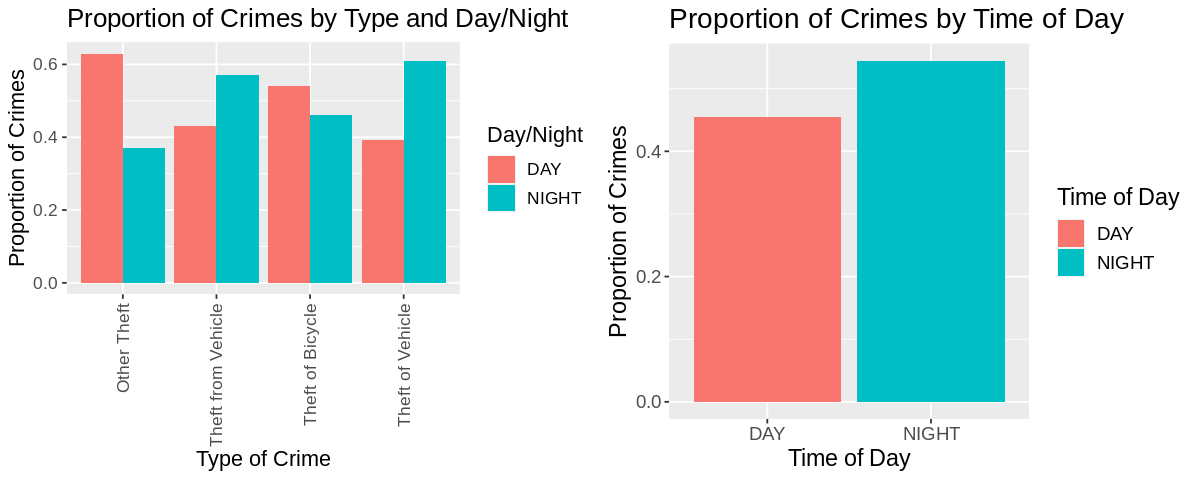

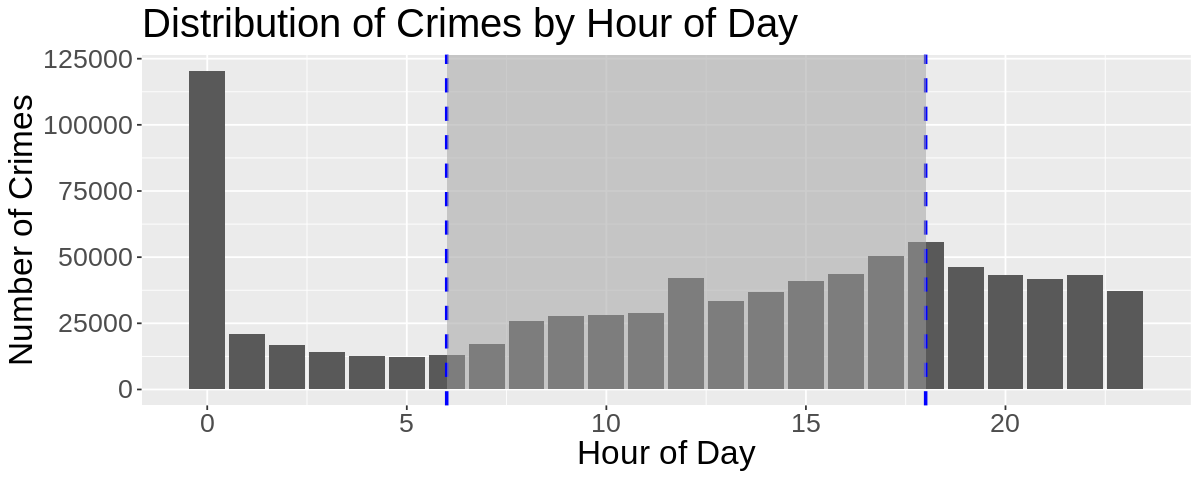

In [47]:
options(repr.plot.width = 10, repr.plot.height = 4) 
plot_grid(theft_counts_by_type_plot, theft_counts_by_day_night_plot, ncol = 2)
theft_counts_hour_plot

### 3. Methods: Plan
The use of this data is supported by the reliability of the data source and standardized procedures for data collection completed by the Vancouver Police Department, ensuring accuracy and consistency in the classification of crimes and time of occurrence.

Due to privacy and investigative reasons, not all crime data is included in the dataset, so our current graphs do not have a complete picture of crime in Vancouver. And furthermore, we will use this data to infer the proportion of theft occurring during day and night in other Canadian cities of similar population density.

To perform our analysis, we will use $p_0$ and $p_1$ to represent the proportion of theft that occurred at night and day respectively. We will conduct a hypothesis test on the proportions at a significance level of 10%, with $H_0: p_0 = p_1$ (null hypothesis) and $H_a: p_0 > p_1$ (alternative hypothesis). In other words, our null hypothesis is that the proportion of theft occurring during the day is the same as the proportion occurring at night, while our alternative hypothesis is that the proportion occurring at night is higher than daytime. And we will conduct hypothesis testing using both bootstrapping and theory-based methods. Additionally, we will construct a confidence interval using the standard deviation found through bootstrapping.

We are expecting to find less proportion of theft during the day than the night for this report. By obtaining the result, we can raise people's awareness of the time of occurrences of theft in Canada with the support of data. And for later investigation, we would like to suggest analyzing other categories of crime and the time of occurrence to see whether all crimes share similar nature in the time of occurrence.

### 4. References
Statistics Canada (2023). *Census Profile: 2021 Census of Population*. Statistics Canada Catalogue. https://www12.statcan.gc.ca/census-recensement/2021/dp-pd/prof/index.cfm?Lang=E.

Tompson, L., & Bowers, K. (2013). A Stab in the Dark?: A Research Note on Temporal Patterns of Street Robbery. *The Journal of research in crime and delinquency, 50*(4), 616–631. https://doi.org/10.1177/0022427812469114.

Vancouver Police Department (2023). *Crime Data* [Data set]. The Vancouver Police Department. https://geodash.vpd.ca/opendata/.

Van Koppen, P. J., & Jansen, R. W. J. (1999). The Time to Rob: Variations in Time of Number of Commercial Robberies. *Journal of Research in Crime and Delinquency, 36*(1), 7–29. https://doi.org/10.1177/0022427899036001003.